In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

#import lightgbm as lgb
import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

https://www.kaggle.com/manabendrarout/custom-stacking-of-classifiers-gpu-tps-sep2021

manabendrarout

# Parameters

In [2]:
target = 'claim'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 2017
    CVSEED = 2017
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 10
    N_ESTIMATORS = 20000
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 2017
    CVSEED = 2017
    #N_ITERS = 10

In [3]:
def set_seed(seed=2017):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-sep-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_solution.csv")

# Preprocessing

In [5]:
features = [col for col in train.columns if 'f' in col]

In [6]:
train['n_missing'] = train[features].isna().sum(axis=1)
test['n_missing'] = test[features].isna().sum(axis=1)

train['std'] = train[features].std(axis=1)
test['std'] = test[features].std(axis=1)

features += ['n_missing', 'std']

In [7]:
ss = StandardScaler()


In [8]:
test[features]

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f111,f112,f113,f114,f115,f116,f117,f118,n_missing,std
0,0.165850,0.487050,1295.00,0.023100,0.31900,0.901880,573.29,3743.7,2.705700e+12,6221.000000,...,2.0655,0.430880,-10.7410,81606.00,1.1940,1.980400e+14,2017.10,0.46357,1,5.589410e+15
1,0.129650,0.373480,1763.00,0.728840,0.33247,-1.263100,875.55,554370.0,5.955700e+14,934.430000,...,1.5736,-1.071200,11.8320,90114.00,1.1507,4.388000e+16,6638.90,0.28125,0,4.080971e+15
2,0.120190,0.445210,736.26,0.046150,0.29605,0.316650,2659.50,317140.0,3.977800e+14,131.810000,...,2.1364,-1.931200,-3.2804,37739.00,1.1548,1.718100e+14,5844.00,0.13797,1,4.054317e+13
3,0.054008,0.395960,996.14,0.859340,0.36678,-0.170600,386.56,325680.0,-3.432200e+13,-26.473000,...,1.5199,-0.011633,1.3840,26849.00,1.1490,2.138800e+17,6173.30,0.32910,0,1.999852e+16
4,0.079947,-0.006919,10574.00,0.348450,0.45008,-1.842000,3027.00,428150.0,9.291500e+11,5999.400000,...,3.7387,0.757080,-4.9405,50336.00,1.2488,2.151300e+17,2250.10,0.33796,0,1.980389e+16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493469,-0.009112,0.308190,637.64,0.778200,0.41415,-1.068500,651.22,985000.0,6.079700e+15,508.820000,...,2.3325,0.112260,-5.9238,NaN,1.1559,8.163900e+16,857.09,1.56330,2,1.123239e+16
493470,0.088922,0.482650,6924.10,0.025963,0.35540,-0.870200,2514.20,18004.0,6.073500e+14,-0.008665,...,1.7005,97.813000,4.3793,-2432.00,1.0707,4.691800e+16,7497.10,0.67075,0,4.335915e+15
493471,0.140620,0.484750,1797.10,0.147020,0.28803,-1.407100,434.03,333050.0,2.351000e+15,33492.000000,...,1.6827,NaN,8.0633,2471.40,1.1725,7.900900e+16,2904.60,0.18005,5,7.433839e+15
493472,0.168000,0.351760,454.79,0.164580,0.16983,0.323850,2331.20,223980.0,-2.795300e+12,93.561000,...,1.3531,155.210000,13.9630,-11.44,1.1946,-1.770600e+14,6763.10,0.33223,0,1.172729e+16


In [9]:
train[target]

0         1
1         0
2         1
3         1
4         1
         ..
957914    0
957915    1
957916    0
957917    1
957918    0
Name: claim, Length: 957919, dtype: int64

# XGB

In [10]:
xgb_params = {
    #'objective': 'binary',
     'n_estimators':N_ESTIMATORS,
     #'importance_type': 'gain',
     #'metric':'auc',
     #'boosting_type': 'gbdt',
     'n_jobs' : -1,
        
   
    'learning_rate': 0.011159116340385172,
    'reg_lambda': 0.07868674215849121,
    'reg_alpha': 26.263704018098185,
    'max_depth': 5,
    'subsample': 0.7612480691247493,
    'colsample_bytree': 0.2695349533886053,
    'booster': 'gbtree',

    'tree_method':'gpu_hist',
    'gpu_id': 0,
    'predictor': 'gpu_predictor'
}

In [11]:
xgb_oof = np.zeros(train.shape[0])
xgb_pred = np.zeros(test.shape[0])
xgb_importances = pd.DataFrame()


kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED+17, SEED+18, SEED+19]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[features], y=train[target])):
    print(f"===== fold {fold} =====")


    X_train = train[features].iloc[trn_idx]
    y_train = train[target].iloc[trn_idx]
    X_valid = train[features].iloc[val_idx]
    y_valid = train[target].iloc[val_idx]
    X_test = test[features]

    start = time.time()
    for inseed in seed_list:
        xgb_params['random_state'] = inseed

        pre_model = xgb.XGBClassifier(**xgb_params)
        pre_model.fit(
            X_train, 
            y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric='auc',
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            verbose=VERBOSE,
        )

        xgb_params2 = xgb_params.copy()
        xgb_params2['reg_lambda'] *= 0.9
        xgb_params2['reg_alpha'] *= 0.9
        xgb_params2['learning_rate'] *= 0.1
        model = xgb.XGBClassifier(**xgb_params2)
        model.fit(
                X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric='auc',
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE,
                xgb_model=pre_model
        )    

        with open(f"xgb_model{fold}_seed{inseed}.pkl", 'wb') as f:
            pickle.dump(model, f)

        fi_tmp = pd.DataFrame()
        fi_tmp['feature'] = X_train.columns
        fi_tmp['importance'] = model.feature_importances_
        fi_tmp['fold'] = fold
        fi_tmp['seed'] = inseed
        xgb_importances = xgb_importances.append(fi_tmp)

        xgb_oof[val_idx] += model.predict_proba(X_valid)[:,-1] / len(seed_list)
        xgb_pred += model.predict_proba(X_test)[:,-1] / len(seed_list)


    elapsed = time.time() - start
    auc = roc_auc_score(y_valid, xgb_oof[val_idx])
    print(f"fold {fold} - xgb auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")            

xgb_pred /= N_SPLITS
print(f"oof xgb_auc = {roc_auc_score(train[target], xgb_oof)}")

np.save("xgb_oof.npy", xgb_oof)
np.save("xgb_pred.npy", xgb_pred)

===== fold 0 =====
[0]	validation_0-auc:0.79991
[299]	validation_0-auc:0.79957
[0]	validation_0-auc:0.79961
[1000]	validation_0-auc:0.80151
[2000]	validation_0-auc:0.80470
[3000]	validation_0-auc:0.80730
[4000]	validation_0-auc:0.80895
[5000]	validation_0-auc:0.81006
[6000]	validation_0-auc:0.81084
[7000]	validation_0-auc:0.81147
[8000]	validation_0-auc:0.81194
[9000]	validation_0-auc:0.81234
[10000]	validation_0-auc:0.81266
[11000]	validation_0-auc:0.81293
[12000]	validation_0-auc:0.81320
[13000]	validation_0-auc:0.81343
[14000]	validation_0-auc:0.81362
[15000]	validation_0-auc:0.81378
[16000]	validation_0-auc:0.81395
[17000]	validation_0-auc:0.81408
[18000]	validation_0-auc:0.81421
[19000]	validation_0-auc:0.81434
[19999]	validation_0-auc:0.81446
[0]	validation_0-auc:0.53827
[1000]	validation_0-auc:0.81135
[2000]	validation_0-auc:0.81395
[3000]	validation_0-auc:0.81500
[4000]	validation_0-auc:0.81565
[5000]	validation_0-auc:0.81607
[6000]	validation_0-auc:0.81630
[7000]	validation_0-

# OOF predictions

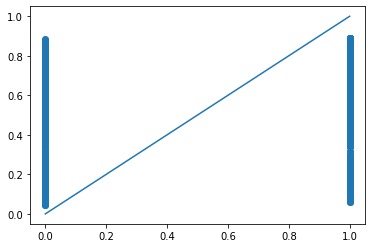

In [12]:
plt.plot(train[target], train[target])
plt.scatter(train[target], xgb_oof)

# Features importances

Text(0.5, 1.0, 'LightGBM feature importances')

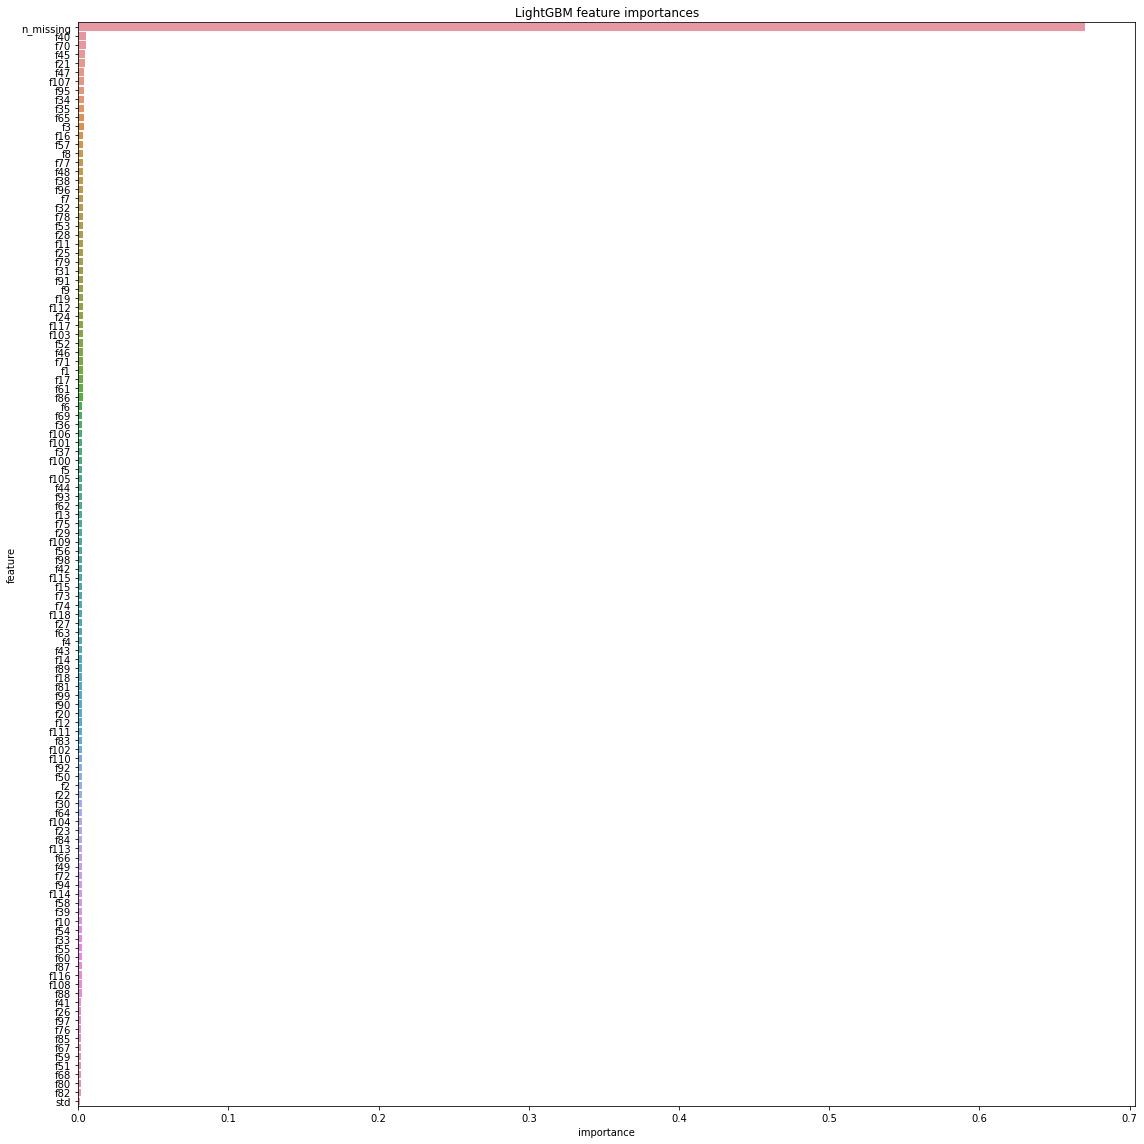

In [13]:
order = list(xgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=xgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("LightGBM feature importances")

# Submission

In [14]:
submission[target] = xgb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,claim
0,957919,0.581902
1,957920,0.118309
2,957921,0.625900
3,957922,0.134415
4,957923,0.149567
...,...,...
493469,1451388,0.806575
493470,1451389,0.115554
493471,1451390,0.770710
493472,1451391,0.135128


# Log

2017 ver2
2018-2022 ver3
2023-2026 ver4
2027-2031 ver5
2032-2033 ver6
2034-2036 ver7